### Contents
A Model Without an Activation Function<br>
&emsp;Linear Example<br>
&emsp;Quadratic Example<br>


In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor


### A Model without an Activation Function

In [ ]:
def create_linear_data(weight:float, bias: float) -> tuple[List[float], List[float]]:
    X = [float(x) for x in range(-10, 10)]
    y = [weight*x+bias for x in X]
    X, y = np.array(X, dtype=np.float32), np.array(y, np.float32)
    X = np.reshape(X, (len(X), 1))
    y = np.reshape(y, (len(y), 1))
    return X, y

# We need to reshape X and y so that each row is a single feature/label.
# This is needed for training.
X_train, y_train = create_linear_data(5, 9)

print('X_train Dimenstions:',X_train.ndim)
print('X_train Shape:', X_train.shape)
print(X_train[:2])

print('y_train Dimenstions:',y_train.ndim)
print('y_train Shape:', y_train.shape)
print(y_train[:2])

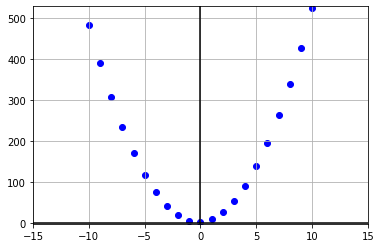

In [4]:
def plot_data(x: np.ndarray, y1: np.ndarray, y2: np.ndarray=None) -> None:
    ax = plt.subplots()[1]
    ax.set_xlim(x.min()-5, x.max()+5)
    ax.set_ylim(y1.min()-5, y1.max()+5)
    plt.scatter(x, y1, color='blue')
    if not y2 is None:
        ax.scatter(x, y2, color='red')
    plt.grid(True)
    plt.axhline(color='black')
    plt.axvline(color='black')

plot_data(X_train, y_train)

Design the Model

In [ ]:
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()

        self.linear1 = nn.Linear(1, 1, bias=True)

    def forward(self, input, log=False):
        l1 = self.linear1(input)
        if log:
            print('\nLinear 1:', l1, l1.shape)
        return l1


Test the Untrained Model with a Single Prediction

In [ ]:
model = LinearRegressionModel()
X = torch.tensor([1], dtype=torch.float32)
prediction = model(X, log=True)
print(X)
print(prediction)

Create a Training Function

In [11]:

# When you have a large number of iterations over a small training set you are basically
# memorizing your training set.

EPOCHS = 100
LR = 0.01

def train_model(model: nn.Module, X_train, y_train) -> tuple[nn.Module, List]:
    torch.manual_seed(42)
    losses = []
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        total_loss = 0
        for X, y in zip(X_train, y_train):

            # Wrap in tensors
            X_tensor = torch.from_numpy(X)
            y_tensor = torch.from_numpy(y)
            
            # Pytorch accumulates gradients so before passing in a new
            # context (features) you need to zero out the gradients from the 
            # previous context.
            model.zero_grad()
            optimizer.zero_grad()

            # Forward pass - this will get log probabilities for every word 
            # in our vocabulary which is now represented as embeddings.
            prediction = model(X_tensor)

            # Compute the loss.
            # target has to be a list for some reason.
            loss = loss_function(prediction, y_tensor)

            # Backward pass to update the gradients.
            loss.backward()

            # Optimize the parameters
            optimizer.step()

            # Get the loss for this context.
            total_loss += loss.item()
            
        # Save the total loss for this epoch.
        losses.append(total_loss)

    return model, losses

In [5]:
def print_results(model: nn.Module, losses: list) -> None:
    # Print the losses of every 10th epoch.
    for epoch in range(0, EPOCHS, 10):
        print(epoch, ':', losses[epoch])
    # This will print the very last epoch so we can see the
    # final loss value.
    print(EPOCHS-1, ':', losses[EPOCHS-1])

    for name, parameter in model.named_parameters():
        print(name, parameter.data)

In [ ]:

model = LinearRegressionModel()
model, losses = train_model(model, X_train, y_train)

# The loss should decrease with every iteration (epoch) over the training data.
print_results(model, losses)

In [ ]:
predictions = [model(torch.from_numpy(X)).detach().item() for X in X_train]

plot_data(np.array(X_train), np.array(y_train), np.array(predictions))

In [ ]:
print(y_train)
print(predictions)

### A Quadratic Example

In [3]:
def create_quadratic_data(a:float, b: float, c:float) -> tuple[List[float], List[float]]:
    X = [float(x) for x in range(-10, 11)]
    y = [a*(x**2)+(b*x)+c for x in X]
    X, y = np.array(X, dtype=np.float32), np.array(y, np.float32)
    X = np.reshape(X, (len(X), 1))
    y = np.reshape(y, (len(y), 1))
    return X, y

X_train, y_train = create_quadratic_data(5, 2, 3)

print('X_train Dimenstions:',X_train.ndim)
print('X_train Shape:', X_train.shape)
print(X_train[:2])

print('y_train Dimenstions:',y_train.ndim)
print('y_train Shape:', y_train.shape)
print(y_train[:2])

X_train Dimenstions: 2
X_train Shape: (21, 1)
[[-10.]
 [ -9.]]
y_train Dimenstions: 2
y_train Shape: (21, 1)
[[483.]
 [390.]]


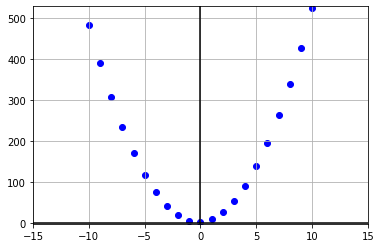

In [12]:
plot_data(X_train, y_train)

In [7]:
class QuadraticRegressionModel(nn.Module):

    def __init__(self):
        super(QuadraticRegressionModel, self).__init__()

        self.linear1 = nn.Linear(1, 6, bias=True)
        self.linear2 = nn.Linear(6, 6, bias=True)
        self.linear3 = nn.Linear(6, 1, bias=True)

    def forward(self, x, log=False):
        x = F.dropout(F.relu(self.linear1(x)), p=0.5)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        #out = self.linear1(input)
        #out = F.relu(out)
        #out = F.dropout(out, p=0.5)
        #out = self.linear2(out)
        #out = F.relu(out)
        #out = self.linear3(out)
        return x

Test the Untrained Model with a Single Prediction

In [ ]:
model = QuadraticRegressionModel()
X = torch.tensor([1], dtype=torch.float32)
prediction = model(X, log=True)
print(X)
print(prediction)

In [13]:
model = QuadraticRegressionModel()
model, losses = train_model(model, X_train, y_train)

# The loss should decrease with every iteration (epoch) over the training data.
print_results(model, losses)

0 : 3974096458502.623
10 : nan
20 : nan
30 : nan
40 : nan
50 : nan
60 : nan
70 : nan
80 : nan
90 : nan
99 : nan
linear1.weight tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]])
linear1.bias tensor([nan, nan, nan, nan, nan, nan])
linear2.weight tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])
linear2.bias tensor([nan, nan, nan, nan, nan, nan])
linear3.weight tensor([[nan, nan, nan, nan, nan, nan]])
linear3.bias tensor([nan])


Plot labels and predictions

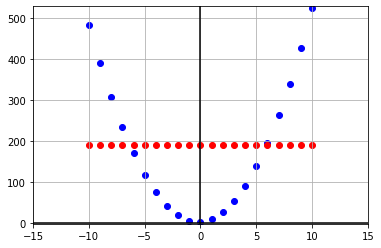

In [9]:
#model.eval() # Tell the model we are evaluating it so that it does not learn or dropout.
predictions = [model(torch.from_numpy(X)).detach().item() for X in X_train]

plot_data(np.array(X_train), np.array(y_train), np.array(predictions))

In [ ]:
activation_functions = {
    'ELU': nn.ELU(),
    'Hardshrink': nn.Hardshrink(),
    'Hardsigmoin': nn.Hardsigmoid(),
    'Hardswish': nn.Hardswish(),
    'Hardtanh': nn.Hardtanh(),
    'LeadkyReLU': nn.LeakyReLU(),
    'LogSigmoid': nn.LogSigmoid(),
    #'MultiheadAttention': nn.MultiheadAttention(embed_dim, num_heads),
    'PReLU': nn.PReLU(),
    'ReLU': nn.ReLU(),
    'ReLU6': nn.ReLU6(),
    'RReLU': nn.RReLU(),
    'SELU': nn.SELU(),
    'CELU': nn.CELU(),
    'GELU': nn.GELU(),
    'Sigmoid': nn.Sigmoid(),
    'SiLU': nn.SiLU(),
    'Mish': nn.Mish(),
    'Softplus': nn.Softplus(),
    'Softshrink': nn.Softshrink(),
    'Softsign': nn.Softsign(),
    'Tanh': nn.Tanh(),
    'Tanhshrink': nn.Tanhshrink(),
    'Threshold': nn.Threshold(),
    #'GLU': nn.GLU(),
    #'Softmin': nn.Softmin(),
    #'Softmax': nn.Softmax(),
    #'Softmax2d': nn.Softmax2d(),
    #'LogSoftmax': nn.LogSoftmax(),
    #'AdaptiveLogSoftmaxWithLoss': nn.AdaptiveLogSoftmaxWithLoss()
}